In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re

import acquire
import prepare

#ignore minor warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_in = acquire.get_data(query_url = False)
print(df_in.shape)
df_in = prepare.prepare_dataframe(df_in)
train, validate, test = prepare.split_data(df_in)
train.shape, validate.shape, test.shape

Found file in working directory!
(70932, 83)


((40311, 60), (20155, 60), (20156, 60))

In [3]:
# Distribution of the usd column
train[['usd']].describe().T

,count,mean,std,min,25%,50%,75%,max
usd,40311.0,6.433689,81.703306,0.01,0.1,0.22,1.02,6999.99


There are a lot of outliers!

<AxesSubplot:>

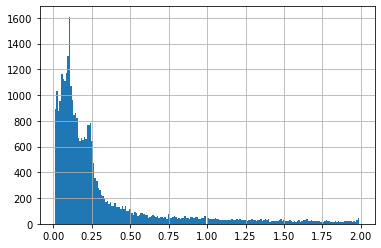

In [4]:
train[train['usd'] < 2].usd.hist(bins = 200)

# Question 1: What effect does release date have on the price?

## Key takeaway
- 1993, 1994 and 1999 have a higher than average price for cards released in those years.

## Discusion
In charting the usd price as a line graph, it appears that there are spikes in the price in the '90s, and possible in the '20s. In charting mean price per year in a 

## Visualization

It looks like the mid '90s, just before '00, and post-'20 might have higher prices

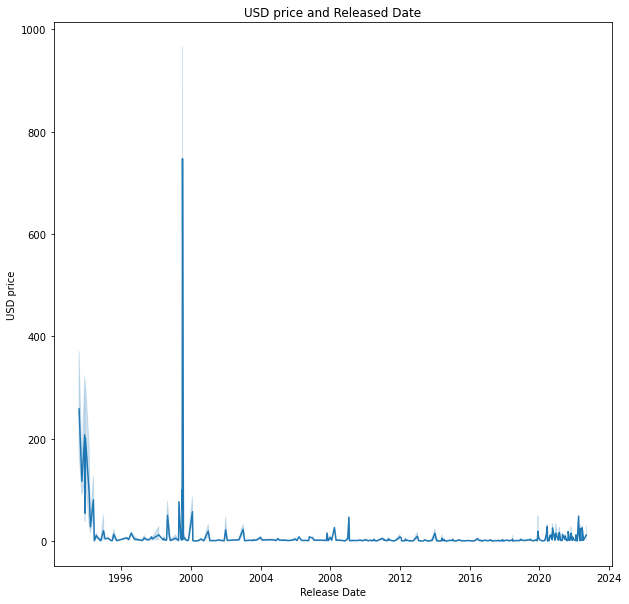

In [5]:
def vis_usd_by_released_at(df):
    plt.figure(figsize=(10,10))
    sns.lineplot(data=df[df['usd'] > 0], x='released_at', y='usd')
    plt.title('USD price and Released Date')
    plt.xlabel('Release Date')
    plt.ylabel('USD price')
    plt.show()

vis_usd_by_released_at(train)

Looks like '93 and '94 have the highest average price, followed by '98 and '99. The spikes in the line graph are not effecting the average price in the year.

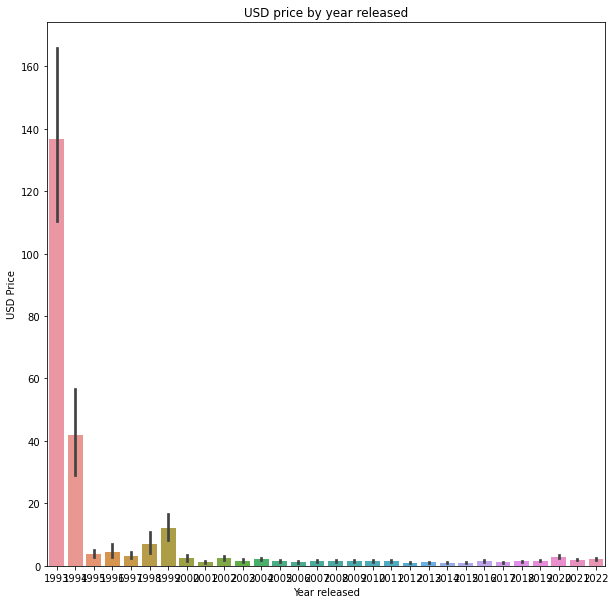

In [6]:
def make_year_released_column(df):
    df['year_released'] = df['released_at'].dt.year
    return df

def vis_usd_by_year(df):
    df = make_year_released_column(df)
    plt.figure(figsize=(10,10))
    sns.barplot(data=df[df['usd'] > 0], x='year_released', y='usd')
    plt.title('USD price by year released')
    plt.xlabel('Year released')
    plt.ylabel('USD Price')
    plt.show()
    
vis_usd_by_year(train)

## Hypothesis Testing

$H_0$ Year $x$ has a average price per card equal to or less than the general average price.

$H_a$ Year $x$ has a average price per card greater than the general average price.

In [7]:
def hypothesis_test_years(df, alpha = 0.05):
    years_to_test = df['year_released'].unique().tolist()
    outputs = []
    for year in years_to_test:
        in_year_sample = df[(df['year_released'] == year) & (df['usd'] > 0)]['usd']
        overall_mean = df['usd'].mean()
        t, p = stats.ttest_1samp(in_year_sample, overall_mean)
        output = {
            'year':year,
            'year_mean':in_year_sample.mean(),
            't_stat':t,
            'p_value':p,
            'reject_null': t > 0 and p/2 < alpha
        }
        outputs.append(output)
    return pd.DataFrame(outputs)

hypothesis_test_years(train).sort_values('reject_null', ascending = False).head(5)

,year,year_mean,t_stat,p_value,reject_null
24,1994,41.753568,5.076309,4.697974e-07,True
23,1993,136.695879,9.072537,6.133079e-19,True
20,1999,11.965388,2.540423,1.119745e-02,True
0,2017,1.191322,-59.796312,0.000000e+00,False
1,2001,1.308977,-37.885491,2.464977e-182,False


The null is likely wrong for '93, '99 and '94.  These years have a higher than average price for their cards.

# Question 2: What effect does basic card type have on price?

## Key takeaway
- Land, artifacts, enchantment and legendary are priced higher than other cards

## Discusion
Land, artifact, enchantment and legendary cards have a statistically higher price than other cards. Some further questions to be asked is if these card types have more rares or particular artists.  In addition, it might be worth looking at subsets of some of these.

## Visualization

Definitely looks like the card type has an effect.

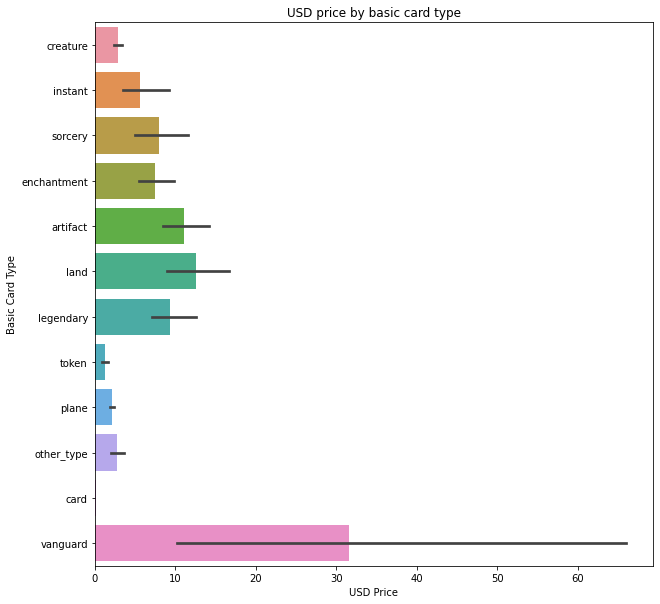

In [8]:
def make_card_type_column(df):
    card_cats = ['Card', 'Vanguard', 'Plane', 'Creature', 'Land', 'Enchantment', 'Artifact', 'Sorcery', 'Instant', 'Legendary', 'Token']
    df['card_type'] = 'other_type'
    for card_cat in card_cats:
        df.loc[df['type_line'].str.contains(card_cat).fillna(False), 'card_type'] = card_cat.lower()
    df.loc[df['type_line'].str.contains('Card // Card').fillna(False), 'card_type'] = 'split_card'
    return df

def vis_by_card_type(df):
    df = make_card_type_column(df)
    plt.figure(figsize=(10,10))
    sns.barplot(data=df[df['usd'] > 0], y='card_type', x='usd')
    plt.title('USD price by basic card type')
    plt.xlabel('USD Price')
    plt.ylabel('Basic Card Type')
    plt.show()
    
vis_by_card_type(train)

In [9]:
make_card_type_column(train).groupby('card_type').usd.describe()

,count,mean,std,min,25%,50%,75%,max
card_type,,,,,,,,
artifact,3891.0,11.059594,95.527098,0.01,0.1200,0.290,1.7900,3099.99
card,20.0,0.120000,0.089912,0.01,0.0550,0.090,0.1875,0.30
creature,15127.0,2.840369,31.472724,0.01,0.0700,0.150,0.3900,2499.94
enchantment,4034.0,7.475025,68.037474,0.01,0.1100,0.260,1.9400,2849.99
instant,4859.0,5.551062,105.282756,0.01,0.0800,0.170,0.5700,6999.99
land,4140.0,12.530761,131.352571,0.03,0.1400,0.260,1.4800,6000.00
legendary,2827.0,9.310007,79.840352,0.01,0.3300,1.510,5.5150,3888.00
other_type,143.0,2.769161,5.140162,0.05,0.2750,0.790,2.7150,38.14
plane,120.0,2.065583,1.480464,0.52,1.3475,1.690,2.4250,14.42


## Hypothesis Testing

$H_0$ : Mean price for card type $x$ is less than or equal to the overall mean price.

$H_a$ : Mean price for card type $x$ is greater than the overall mean price.

In [10]:
def hypothesis_test_card_type(df, alpha = 0.05):
    card_types_to_test = df['card_type'].unique().tolist()
    outputs = []
    for card_type in card_types_to_test:
        in_card_sample = df[(df['card_type'] == card_type) & (df.usd > 0.01)]['usd']
        overall_mean = df['usd'].mean()
        t, p = stats.ttest_1samp(in_card_sample, overall_mean)
        output = {
            'card_type':card_type,
            'overall_mean':overall_mean,
            'card_type_mean':in_card_sample.mean(),
            't_stat':t,
            'p_value':p,
            'reject_null': t > 0 and p/2 < alpha
        }
        outputs.append(output)
    return pd.DataFrame(outputs)

hypothesis_test_card_type(train).sort_values('reject_null', ascending = False)

,card_type,overall_mean,card_type_mean,t_stat,p_value,reject_null
4,artifact,6.433689,11.241445,3.088901,2.023393e-03,True
5,land,6.433689,12.530761,2.986640,2.837148e-03,True
6,legendary,6.433689,9.316591,1.918514,5.514653e-02,True
0,creature,6.433689,2.951802,-13.093473,5.956357e-39,False
1,instant,6.433689,5.694970,-0.476732,6.335749e-01,False
2,sorcery,6.433689,8.065635,0.970315,3.319422e-01,False
3,enchantment,6.433689,7.580113,1.055432,2.912921e-01,False
7,token,6.433689,1.227304,-28.030601,3.789460e-111,False
8,plane,6.433689,2.065583,-32.321076,9.222349e-61,False
9,other_type,6.433689,2.769161,-8.525292,2.040294e-14,False


# Question 3 : What effect does the game style (arena etc) have on price?

## Key takeaway
- Cards available exclusively in the paper game are more valuable than ones also available in other games.

## Discusion
Each card is tested by its inclusion in each game type, and cards that are in the paper game exclusively are more expensive. Inclusion into the other game types appears to lower the value of the card.

## Notes
The column contains a list of options to make a number of boolean columns to visualize.

## Visualization

Cards that are in the paper game are definitely more valuable than cards available only in the non-paper game.

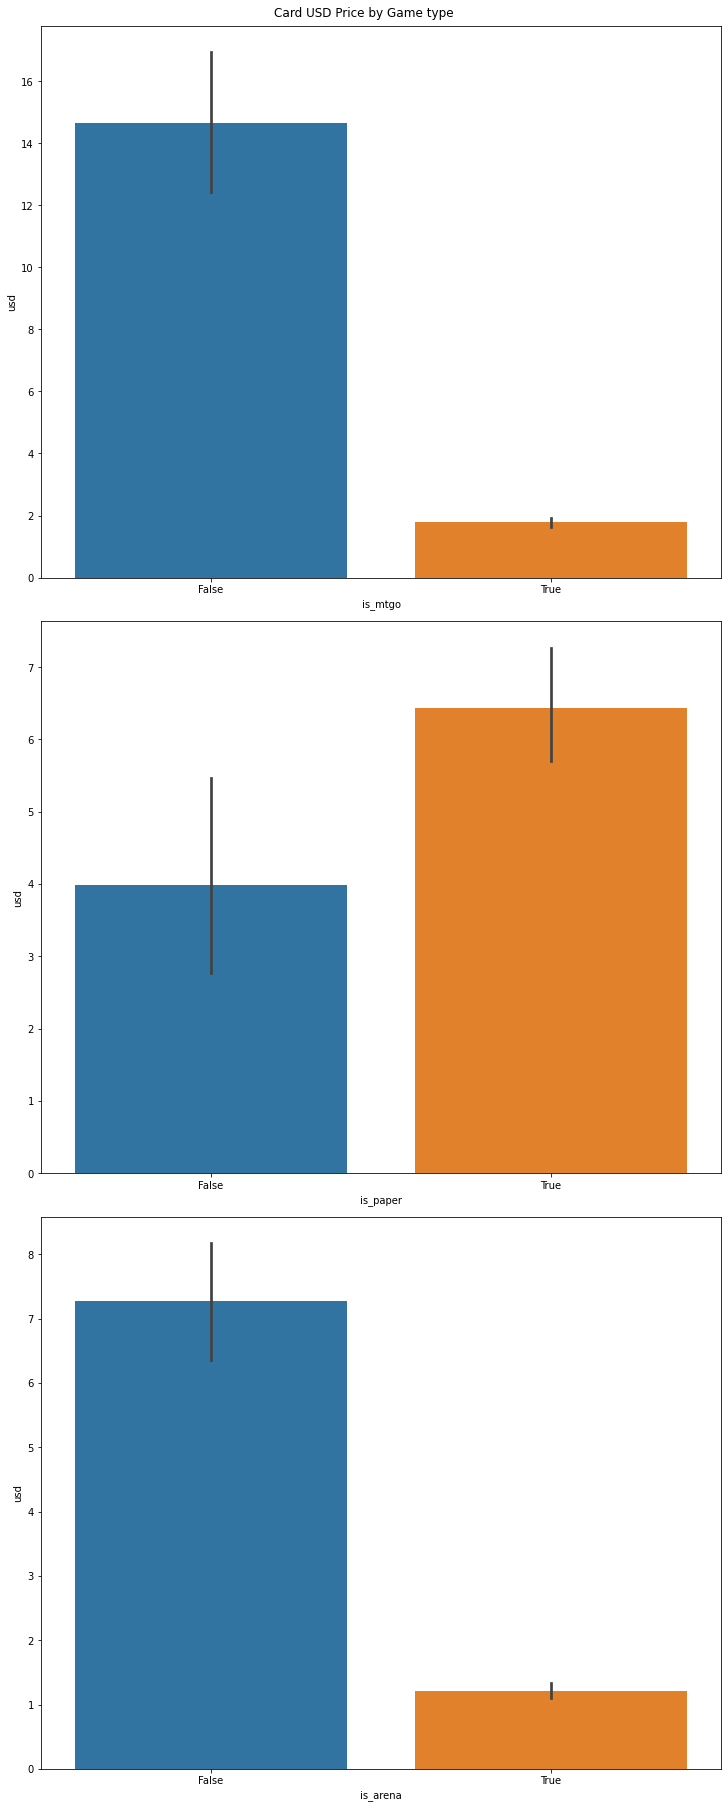

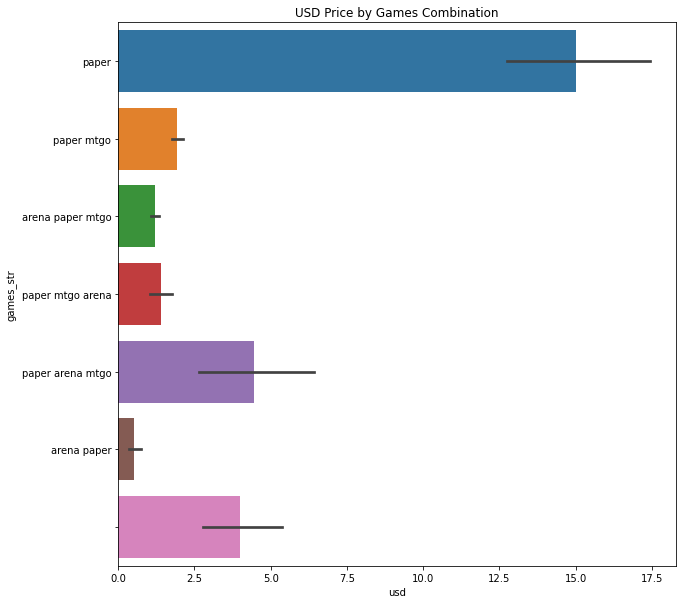

In [11]:
def make_games_boolean_columns(df):
    df_new = df[['id', 'usd', 'name', 'games']].copy()
    games_values = []
    for r in df.games:
        games_values += r
    game_values = list(set(games_values))
    df_new['games_str'] = df_new['games'].apply(lambda r : ' '.join(r))
    for game_type in game_values:
        df_new[f'is_{game_type.lower()}'] = df_new.games_str.str.contains(game_type)
    return df_new

def vis_game_type(df):
    games_df = make_games_boolean_columns(df)
    bool_columns = games_df.select_dtypes(include=bool).columns
    fig, axes = plt.subplots(3, 1, figsize = (10, 25), constrained_layout=True)
    for i, bool_col in enumerate(bool_columns):
        sns.barplot(data = games_df, x=bool_col, y='usd', ax = axes[i])
    fig.suptitle('Card USD Price by Game type')
    plt.show()

def vis_game_type_by_combo(df):
    df_new = df[['id', 'usd', 'name', 'games']].copy()
    df_new['games_str'] = df_new['games'].apply(lambda r : ' '.join(r))
    plt.figure(figsize=(10,10))
    sns.barplot(data = df_new, y='games_str', x='usd')
    plt.title('USD Price by Games Combination')
    plt.show()
    
vis_game_type(train)
vis_game_type_by_combo(train)

## Hypothesis Testing

$H_0$ : The mean usd price for cards which are available in game type $x$ is less than or equal to the mean usd price of those not available in game type $x$.

$H_a$ : The mean usd price for cards which are available in game type $x$ is greater than the mean usd price of those not available in game type $x$.

Where $x$ is paper, astral, mtgo, arena, or sega.

In [12]:
def hypothesis_test_game_type(df, alpha = 0.05):
    games_df = make_games_boolean_columns(df)
    bool_columns = games_df.select_dtypes(include=bool).columns
    outputs = []
    for bool_col in bool_columns:
        is_true_sample = games_df[(games_df[bool_col])]['usd']
        overall_mean = games_df['usd'].mean()
        t, p = stats.ttest_1samp(is_true_sample, overall_mean)
        output = {
            'game_type':bool_col,
            'card_count': games_df[(games_df[bool_col]) & (games_df.usd > 0.01)]['usd'].count(),
            'game_type_mean':is_true_sample.mean(),
            't_stat':t,
            'p_value':p,
            'reject_null': t > 0 and p/2 < alpha
        }
        outputs.append(output)
    return pd.DataFrame(outputs)

hypothesis_test_game_type(train).sort_values('reject_null', ascending=False)

,game_type,card_count,game_type_mean,t_stat,p_value,reject_null
0,is_mtgo,24922,1.787554,-63.769316,0.000000,False
1,is_paper,39356,6.437399,0.009104,0.992737,False
2,is_arena,5072,1.205419,-87.500291,0.000000,False


$H_0$ : The mean usd price for cards which are available $l$ games is less than or equal to the mean usd price of those not available in $l$ games.

$H_a$ : The mean usd price for cards which are available $l$ games is greater than the mean usd price of those not available in $l$ games.

Where $l$ is one of the following combinations: 
- 'paper'
- 'paper', 'mtgo'
- 'arena', 'paper', 'mtgo'
- 'mtgo'
- 'arena'
- 'paper', 'mtgo', 'arena'
- 'arena', 'paper'
- no combination
- 'paper', 'arena', 'mtgo'
- 'astral'
- 'sega'

In [13]:
def hypothesis_test_game_type_combinations(df, alpha = 0.05):
    games_df = df[['id', 'usd', 'name', 'games']].copy()
    games_df['games_str'] = games_df['games'].apply(lambda r : ' '.join(r))
    test_values = games_df['games_str'].value_counts().index.tolist()
    outputs = []
    for test_val in test_values:
        in_sample = games_df[(games_df['games_str'] == test_val)]['usd']
        overall_mean = games_df['usd'].mean()
        t, p = stats.ttest_1samp(in_sample, overall_mean)
        output = {
            'games_combination':test_val,
            'card_count':games_df[(games_df['games_str'] == test_val) & (games_df.usd > 0.01)]['usd'].count(),
            'in_sample_mean':in_sample.mean(),
            't_stat':t,
            'p_value':p,
            'reject_null': t > 0 and p/2 < alpha
        }
        outputs.append(output)
    return pd.DataFrame(outputs)
    
hypothesis_test_game_type_combinations(train).sort_values('reject_null', ascending=False)

,games_combination,card_count,in_sample_mean,t_stat,p_value,reject_null
1,paper,14132,15.018361,7.490320,7.276010e-14,True
0,paper mtgo,20152,1.927415,-49.955943,0.000000e+00,False
2,arena paper mtgo,4163,1.202358,-78.480391,0.000000e+00,False
3,paper mtgo arena,572,1.386755,-26.366627,2.007565e-104,False
4,arena paper,302,0.530062,-58.087016,4.910872e-172,False
5,,61,3.985574,-3.507827,8.626413e-04,False
6,paper arena mtgo,35,4.466000,-1.991392,5.452106e-02,False


# What is the overlap between card types and rarity?

## Key takeaway
- certain combinations of rarity and card type are more valuable than others; for example, rare enchantments are more valuable--but a enchantment card is not above average by itself.

## Discusion

USD price is only significant for artifact, land and legendary; however, when some cards are also a certain rarity, then they become valuable.  This indicates that these two columns should both be used in the model together to try to capture the more valuable cards.

## Visualization
Rare and mythic cards are the most expensive.  However, there are not very many mythic cards.

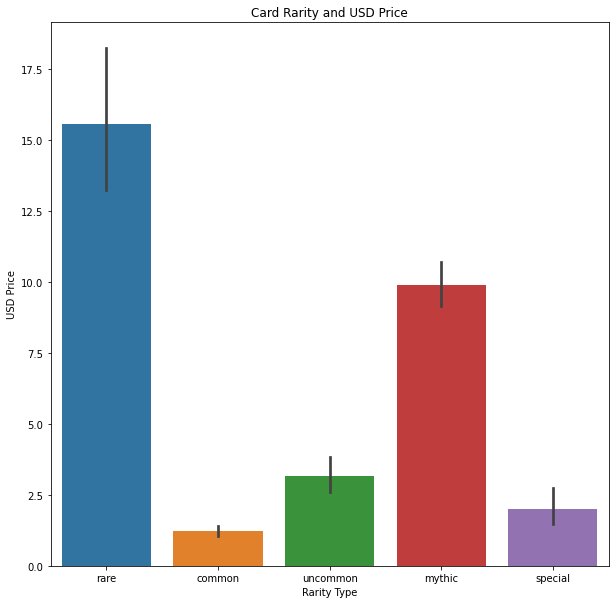

In [14]:
def viz_rarity_price(df):
    plt.figure(figsize=(10,10))
    sns.barplot(data = df, x = 'rarity', y = 'usd', palette = sns.color_palette())
    plt.title('Card Rarity and USD Price')
    plt.xlabel('Rarity Type')
    plt.ylabel('USD Price')
    plt.show()
    
viz_rarity_price(train)

It looks like for mythic tends to have more legendary.  Creatures are more represented in the other card types. Since the uncommon, rare and mythic cards are more expensive, is there a difference in the prices of the different card types?

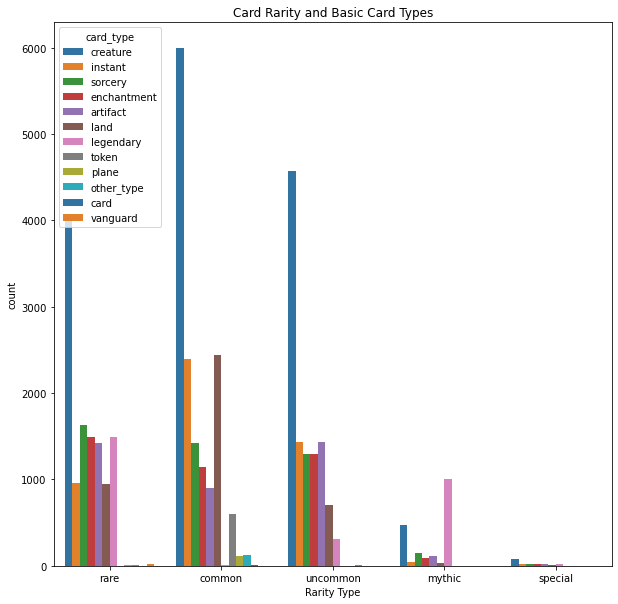

In [15]:
def viz_card_type_rarity(df):
    plt.figure(figsize=(10,10))
    sns.countplot(data = df, x = 'rarity', hue = 'card_type', palette = sns.color_palette())
    plt.title('Card Rarity and Basic Card Types')
    plt.xlabel('Rarity Type')
    plt.show()

viz_card_type_rarity(train)

Within the most expensive rarity types, land and artifact card types were still more expensive.

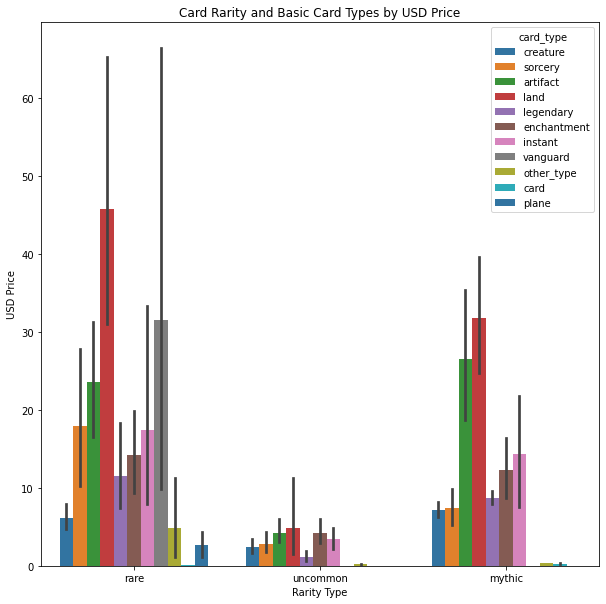

In [16]:
def viz_rare_uncommon_card_type_prices(df):
    plt.figure(figsize=(10,10))
    sns.barplot(data = df[df['rarity'].isin(['rare', 'uncommon', 'mythic'])], x = 'rarity', y= 'usd', hue = 'card_type', palette = sns.color_palette())
    plt.title('Card Rarity and Basic Card Types by USD Price')
    plt.xlabel('Rarity Type')
    plt.ylabel('USD Price')
    plt.show()
    
viz_rare_uncommon_card_type_prices(train)

## Hypothesis Testing

$H_0$ : Cards of $raritytype$ and $cardtype$ have a mean value less than or equal to the overall card mean value.

$H_a$ : Cards of $raritytype$ and $cardtype$ have a mean value greater than the overall card mean value.

Where $raritytype$ is one of 'rare', 'uncommon', 'mythic', and $cardtype$ is any basic card type from the `card_type` columns.

In [17]:
def rarity_card_type_hypothesis_tests(df, alpha = 0.05):
    outputs = []
    rarities_to_test = ['rare', 'uncommon', 'mythic']
    overall_mean = df['usd'].mean()
    for rarity_type in rarities_to_test:
        rarity_df = df[df.rarity == rarity_type]
        card_types_list = rarity_df['card_type'].unique().tolist()
        for card_type in card_types_list:
            subgroup = rarity_df[rarity_df['card_type'] == card_type]['usd']
            t, p = stats.ttest_1samp(subgroup, overall_mean)
            output = {
                'rarity_type':rarity_type,
                'card_type':card_type,
                'overall_mean':overall_mean,
                'subgroup_mean':subgroup.mean(),
                't_stat': t,
                'p_value': p,
                'reject_null': t > 0 and p/2 < alpha
            }
            outputs.append(output)
    return pd.DataFrame(outputs)

rarity_card_type_hypothesis_tests(train).sort_values('reject_null', ascending=False).head(15)

,rarity_type,card_type,overall_mean,subgroup_mean,t_stat,p_value,reject_null
2,rare,land,6.433689,45.751851,4.609644,4.584154e-06,True
3,rare,artifact,6.433689,23.564593,4.209475,2.719814e-05,True
5,rare,enchantment,6.433689,14.174143,2.765816,5.748335e-03,True
6,rare,legendary,6.433689,11.543221,1.800819,7.193407e-02,True
25,mythic,enchantment,6.433689,12.280000,2.884459,4.894132e-03,True
24,mythic,instant,6.433689,14.350465,2.030992,4.861689e-02,True
23,mythic,artifact,6.433689,26.505000,4.598121,1.173936e-05,True
20,mythic,land,6.433689,31.773333,6.324940,6.557570e-07,True
19,mythic,legendary,6.433689,8.725692,5.351288,1.081975e-07,True
1,rare,sorcery,6.433689,17.913771,2.536849,1.127783e-02,True


# Question: What effect does lang have on the price?

## Key takeaways

## Discussion

In [20]:
train.groupby('lang').usd.describe()

,count,mean,std,min,25%,50%,75%,max
lang,,,,,,,,
en,39907.0,6.292161,81.542635,0.01,0.1000,0.220,0.9700,6999.99
es,130.0,12.751308,21.833174,0.19,1.9925,4.985,15.3600,149.98
fr,112.0,47.988393,175.389885,0.90,3.0000,4.990,20.1250,1299.99
it,26.0,15.722692,35.333452,0.49,2.9900,3.845,12.6700,179.99
ja,104.0,7.105481,17.967376,0.23,1.1650,2.845,6.5075,143.98
ph,4.0,11.755000,10.312858,2.67,6.9150,8.890,13.7300,26.57
zhs,28.0,0.714286,1.257730,0.06,0.1075,0.155,0.4375,4.81


## Note
According to the documentation, the cards that are represented by another language are made exclusively in that language.

## Visualization

It looks like the French cards are the most expensive.

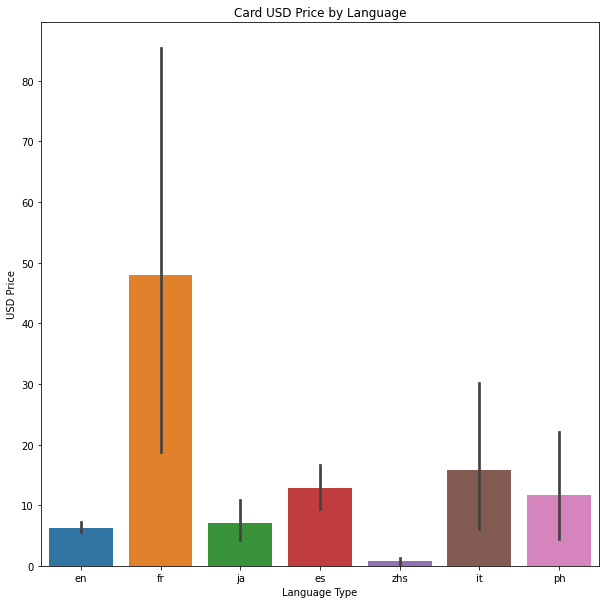

In [24]:
def viz_lang_column_usd(df):
    plt.figure(figsize=(10,10))
    sns.barplot(data = df, x = 'lang', y = 'usd')
    plt.title('Card USD Price by Language')
    plt.xlabel('Language Type')
    plt.ylabel('USD Price')
    plt.show()
    
viz_lang_column_usd(train)

## Hypothesis Testing

In [33]:
def lang_hypothesis_test(df, alpha = 0.05):
    outputs = []
    lang_types = df['lang'].unique().tolist()
    overall_mean = df['usd'].mean()
    for lang_type in lang_types:
        in_sample = df[df['lang'] == lang_type]['usd']
        t, p = stats.ttest_1samp(in_sample, overall_mean)
        output = {
            'langauge':lang_type,
            'overall_mean':overall_mean,
            'legality_mean':in_sample.mean(),
            't_value':t,
            'p_value':p,
            'reject_null': t > 0 and p/2 < alpha
        } 
        outputs.append(output)
    return pd.DataFrame(outputs)

lang_hypothesis_test(train).sort_values('reject_null', ascending=False)

,langauge,overall_mean,legality_mean,t_value,p_value,reject_null
1,fr,6.433689,47.988393,2.507406,1.360934e-02,True
3,es,6.433689,12.751308,3.299197,1.253594e-03,True
0,en,6.433689,6.292161,-0.346722,7.288024e-01,False
2,ja,6.433689,7.105481,0.381300,7.037661e-01,False
4,zhs,6.433689,0.714286,-24.062587,8.941103e-20,False
5,it,6.433689,15.722692,1.340509,1.921353e-01,False
6,ph,6.433689,11.755000,1.031976,3.779905e-01,False
